In [134]:
# 1. Import thư viện cần thiết
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error


In [135]:
#AMZN 7:2:1
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('BABA.csv')
df1 = df.reset_index()['Close']

In [136]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [137]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]   

In [138]:
# 5. Hàm Create Dataset
import numpy

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)
 # Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [139]:
# 6. Định nghĩa mô hình SVR
from sklearn.svm import SVR
model = SVR(kernel='linear')   

In [140]:
# 7. Huấn luyện mô hình với dữ liệu train
model.fit(X_train, y_train)

SVR(kernel='linear')

In [141]:
# 8. Dự đoán giá trị trên tập train, test và validation
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

In [142]:
# 9. Chuẩn hóa dữ liệu dự đoán
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

In [143]:
# 10. Đánh giá độ chính xác của mô hình bằng độ lỗi RMSE trên tập validation và test
test_mse = mean_squared_error(y_test, y_pred)
print("Testing MSE:", test_mse)
valid_mse = mean_squared_error(y_val, y_pred_val)
print("Validation MSE:", valid_mse)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)
valid_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print('Validation RMSE:', valid_rmse)

test_mape = mean_absolute_percentage_error(y_pred, y_test)
print("Testing MAPE:", test_mape)
valid_mape = mean_absolute_percentage_error(y_pred, y_test)
print("Validation MAPE:", valid_mape)

Testing MSE: 13611.798472434673
Validation MSE: 11505.63662523419
Testing RMSE: 116.66961246372027
Validation RMSE: 107.26433062875184
Testing MAPE: 0.9985877271043584
Validation MAPE: 0.9985877271043584


In [144]:
# 11. Dự báo giá cổ phiếu cho 30 ngày tiếp theo
x_input = val_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        i += 1

lst_output = np.array(lst_output).reshape(-1, 1)



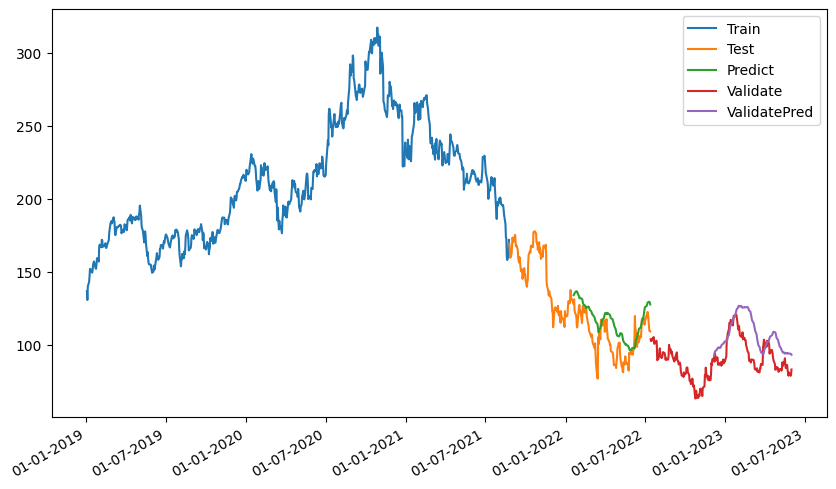

In [145]:
# 12. Vẽ biểu đồ
from matplotlib import dates
df = pd.read_csv('AMZN.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close']

plt.figure(figsize=(10, 6))
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%Y'))
# Xoay và căn chỉnh nhãn trục x
plt.gcf().autofmt_xdate()

plt.plot(df1.index[:train_size], scaler.inverse_transform(train_data))
plt.plot(df1.index[train_size:train_size + test_size], scaler.inverse_transform(test_data))
plt.plot(df1.index[train_size+101:train_size + test_size], y_pred[:test_size - time_step, 0])
plt.plot(df1.index[train_size + test_size:train_size + test_size + val_size], scaler.inverse_transform(val_data))
plt.plot(df1.index[train_size + test_size+101:train_size + test_size + val_size], y_pred_val)

plt.legend(['Train', 'Test', 'Predict', 'Validate', 'ValidatePred'])
plt.show()

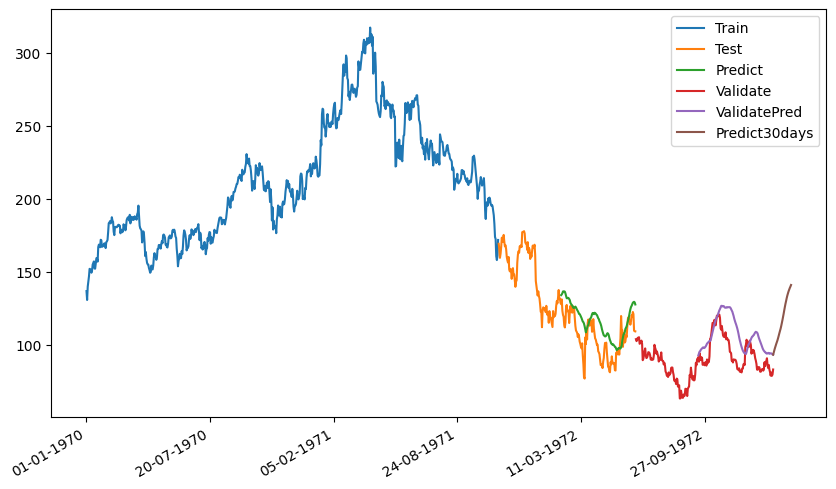

In [146]:
# 13.Vẽ hình
from matplotlib import dates
df = pd.read_csv('AMZN.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close']

plt.figure(figsize=(10, 6))
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%Y'))
# Xoay và căn chỉnh nhãn trục x
plt.gcf().autofmt_xdate()

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()